<a href="https://colab.research.google.com/github/roymuli/Python-Projects/blob/main/Project_3_FINANCIAL_MODELLING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. INTRODUCTION**

- This report examines the impact of Corporate Social Responsibility (CSR) on company performance among UK firms.

- Using a dataset of 400 firms, the analysis explores whether companies engaging in CSR initiatives—such as environmental sustainability and community relations—achieve superior financial outcomes, measured by Market-to-Book Value (MBV) and Return on Capital Employed (ROCE).

- Control variables, including firm size, age, growth, and industry, are incorporated for a comprehensive assessment.

- The findings will provide valuable insights, aiding investment decisions by evaluating the financial benefits of CSR engagement.

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format='{:,.2f}'.format

In [37]:
file_path = '/content/drive/MyDrive/Financial Modelling.csv'

df = pd.read_csv(file_path)

In [38]:
df.head()

,Unnamed: 0,MBV,ROCE,CSR,Growth,Size,Age,Industry
0,0,2.12,43.20,37.10,6.90,966.60,44,energy
1,1,2.42,51.80,38.10,2.20,"2,165.57",47,energy
2,2,2.61,40.70,38.10,7.30,"1,714.76",48,energy
3,3,1.81,30.60,24.80,2.90,"2,589.49",50,energy
4,4,2.61,48.10,33.30,9.90,"3,234.23",42,energy


In [39]:
del df['Unnamed: 0']

In [40]:
df.sample(3)

,MBV,ROCE,CSR,Growth,Size,Age,Industry
181,2.11,34.90,35.70,1.80,"1,722.12",25,transportation
157,2.62,48.50,48.10,7.10,"1,422.17",40,other manufacturing
274,2.46,36.60,37.20,5.80,"2,326.65",50,other manufacturing


# **2.DATA PREPROCESSING**

In [41]:
# check shape
rows, columns = df.shape
print(f'Rows: {rows}\nColumns: {columns}')

Rows: 400
Columns: 7


- The dataset is made up of 400 different firms
- It has 7 columns; MBV, ROCE, CSR, Growth, Size, Age and Industry

In [42]:
# check missing values
df.isna().sum()

,0
MBV,0
ROCE,0
CSR,0
Growth,0
Size,0
Age,0
Industry,0


In [43]:
# check duplicates
df.duplicated().sum()

0

In [44]:
# check for the distribution of the numeric values


**1.AGE**

In [45]:
#create age categories
df['Age_category']= pd.qcut(df['Age'], q=3, labels=['Established', 'Seasoned', 'Veteran'])

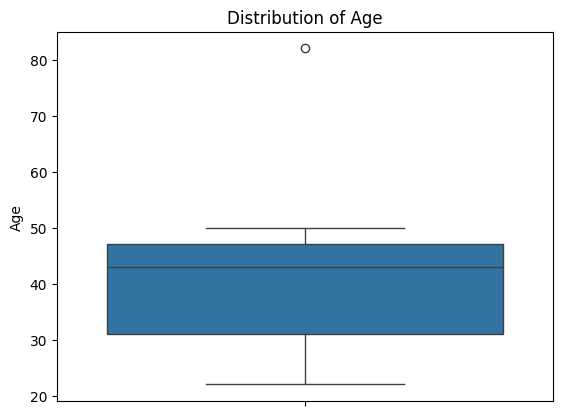

In [46]:
sns.boxplot(df['Age'])
plt.title('Distribution of Age')
plt.show()

In [47]:
# Investigate the outliers in age
df['Age'].describe()

,Age
count,400.00
mean,40.39
std,8.72
min,22.00
25%,31.00
50%,43.00
75%,47.00
max,82.00


- The mean age for these firms is 40.39 years
- The minimum age is 22 years while the maximum is 82 years
- 75% of these firms are 47 years or below

In [48]:
# check age above 50 years
df[df['Age']>50]

,MBV,ROCE,CSR,Growth,Size,Age,Industry,Age_category
75,2.51,51.60,46.20,7.00,"2,017.27",82,other manufacturing,Veteran


- There is only 1 firm above 50 years
- So we can cap age at 50 years to minimize the standard deviation


In [49]:
# calculate IQR
Q1 = df['Age'].quantile(.25)
Q3 = df['Age'].quantile(.75)
IQR = Q3 - Q1


In [50]:
# Calculate lower bound and upper bound
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

In [51]:
# find outliers
outliers = (df['Age']<lower_bound)|(df['Age']>upper_bound)
outliers.sum()

1

In [52]:
#treat outliers
df['Age'] = df['Age'].clip(lower=lower_bound, upper=upper_bound)

In [53]:
#check distribution
df['Age'].describe()

,Age
count,400.00
mean,40.37
std,8.60
min,22.00
25%,31.00
50%,43.00
75%,47.00
max,71.00


In [54]:
df.head(3)

,MBV,ROCE,CSR,Growth,Size,Age,Industry,Age_category
0,2.12,43.20,37.10,6.90,966.60,44,energy,Seasoned
1,2.42,51.80,38.10,2.20,"2,165.57",47,energy,Veteran
2,2.61,40.70,38.10,7.30,"1,714.76",48,energy,Veteran


In [55]:
numerics = df.select_dtypes(include=['float', 'int']).columns

In [56]:
# calculate IQR for all the numericals
#calculate IQR
Q1 = df[numerics].quantile(0.25)
Q3 = df[numerics].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR
outliers = (df[numerics]<lower_bound)|(df[numerics]>upper_bound)
print(outliers.sum())

MBV       16
ROCE       1
CSR       18
Growth     0
Size       1
Age        0
dtype: int64


In [57]:
#treat outliers by capping
for col in numerics:
  df[col]=df[col].clip(lower=lower_bound[col], upper=upper_bound[col])

In [58]:
#check outliers
#df[['CSR','MBV', 'CSR', 'Growth', 'Age' ]].plot(kind='box')

# **3. EXPLORATORY DATA ANALYSIS (EDA)**

## a. Descriptive Statistics

In [59]:
# descriptive statistics
descriptive_stat = df[numerics].describe()
descriptive_stat

,MBV,ROCE,CSR,Growth,Size,Age
count,400.00,400.00,400.00,400.00,400.00,400.00
mean,2.32,38.05,37.46,5.06,"2,023.52",40.37
std,0.42,7.11,7.52,3.40,595.95,8.60
min,1.29,18.85,19.15,-3.00,654.92,22.00
25%,2.08,33.40,33.18,2.58,"1,579.07",31.00
50%,2.32,38.05,37.20,5.20,"2,044.32",43.00
75%,2.61,43.10,42.52,7.30,"2,417.28",47.00
max,3.40,53.80,56.55,12.40,"3,674.59",71.00


**MBV (Market-to-Book Value)**

- Mean: 2.32, with a range from 1.29 to 3.41.
- The data is moderately spread (std: 0.42), indicating most firms have a similar MBV.

**ROCE (Return on Capital Employed, %)**

- Mean: 38.05%, with a range from 18.85% to 53.80%.
- A standard deviation of 7.11 suggests some variability in profitability.

**CSR (Corporate Social Responsibility, %)**

- Mean: 37.46%, ranging from 19.15% to 56.55%.
- A relatively high spread (std: 7.52) indicates variations in CSR initiatives.

**Growth (% Increase in Revenue or Profit)**

- Mean: 5.06%, but some firms experienced negative growth (-3.00%), while others grew by 12.40%.
- The high variability (std: 3.40) shows significant differences in company performance.

**Size (Firm Size, likely measured in revenue/assets)**

- Mean: 2023.52, ranging from 654.92 to 3674.59.
- A large standard deviation (595.95) suggests significant firm size differences.

**Age (Years Since Establishment)**

- Mean: 40.37 years, with firms ranging from 22 to 71 years old.
- A moderate spread (std: 8.60) implies some firms are relatively young, while others are well-established.

In [60]:
#check unique industries
df['Industry'].unique()

array(['energy', 'transportation', 'other services', 'construction',
       'other manufacturing'], dtype=object)

In [73]:
# group by industry
df.groupby('Industry').agg({
    'MBV': 'mean',
    'CSR': 'mean',
    'Size': 'mean',
    'ROCE': 'mean',
    'Age': 'mean'
                                 })


,MBV,CSR,Size,ROCE,Age
Industry,,,,,
construction,2.31,36.60,"1,941.86",36.71,39.87
energy,2.41,38.13,"2,035.20",38.38,41.24
other manufacturing,2.26,37.30,"2,008.10",38.07,40.54
other services,2.22,34.42,"2,096.81",35.57,39.19
transportation,2.30,37.75,"2,022.83",38.55,38.83


- Energy firms have the highest MBV (2.41), CSR (38.13), and ROCE (38.38), indicating strong market valuation and profitability.

- Construction and transportation industries have similar MBV (~2.30), but transportation has higher ROCE (38.55), suggesting better capital efficiency.

- Other services have the lowest CSR (34.42) and ROCE (35.57), indicating lower corporate responsibility and profitability.

- Firm size varies, with other services (2,096.81) being the largest and construction (1,941.86) the smallest.

- Energy firms are the oldest (41.24 years), while transportation is the youngest (38.83 years).

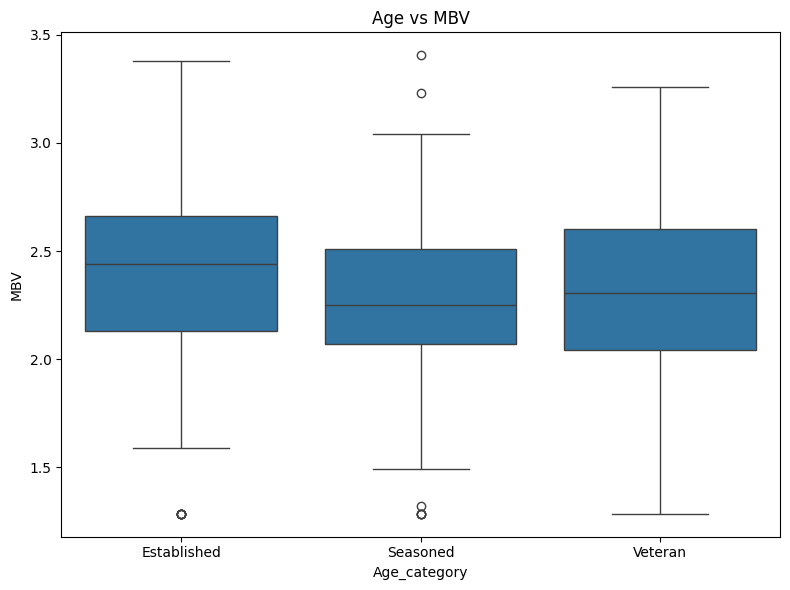

In [74]:
#boxplot for age category
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='Age_category', y='MBV')
plt.title('Age vs MBV')
plt.tight_layout()
plt.show()

In [62]:
#check unique industries
df['Industry'].unique()

array(['energy', 'transportation', 'other services', 'construction',
       'other manufacturing'], dtype=object)

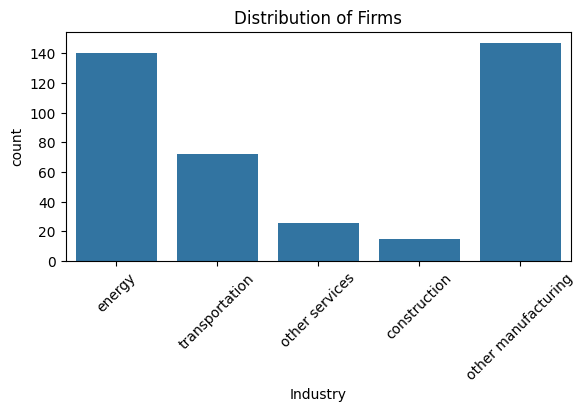

In [80]:
# countplot for industry
plt.figure(figsize=(6,4))
sns.countplot(x=df['Industry'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('Distribution of Firms')
plt.savefig('Industry.jpeg', bbox_inches=None)
plt.show()

In [64]:
# group by age
df.groupby('Age_category').agg({
    'MBV': 'mean',
    'CSR': 'mean',
    'Size': 'mean',
    'ROCE': 'mean',
    'Age': 'mean'
                                 })

,MBV,CSR,Size,ROCE,Age
Age_category,,,,,
Established,2.37,38.33,"2,028.54",38.20,31.55
Seasoned,2.27,36.76,"2,039.77",37.74,43.61
Veteran,2.30,37.00,"2,004.41",38.14,48.05


Takeaways:

- CSR is highest in younger firms (Established category), suggesting they may be more engaged in corporate social responsibility.

- MBV, ROCE, and Size do not vary significantly across the different age categories.

- Older firms (Veterans) have the highest average age (48.05 years) but similar financial and CSR characteristics as younger firms.

## b. Multivariate Analysis

In [65]:
# check the correlation between the numerical values

numerical_val = df.select_dtypes(include=['float', 'int']).columns

correlation_matrix = df[numerical_val].corr()
correlation_matrix

,MBV,ROCE,CSR,Growth,Size,Age
MBV,1.00,0.49,0.77,0.42,0.01,-0.08
ROCE,0.49,1.00,0.62,0.30,0.05,0.02
CSR,0.77,0.62,1.00,0.37,0.04,-0.05
Growth,0.42,0.30,0.37,1.00,0.04,0.01
Size,0.01,0.05,0.04,0.04,1.00,0.02
Age,-0.08,0.02,-0.05,0.01,0.02,1.00


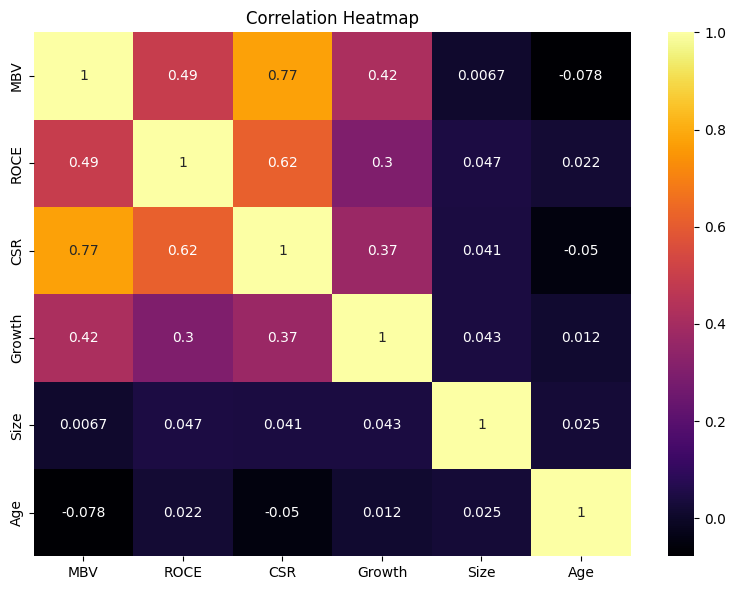

In [66]:
#Visualize the correlation
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='inferno')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

**Key Observations**

**Strong Positive Correlations**

- CSR & MBV (0.77): Higher corporate social responsibility is associated with a higher market valuation.

- CSR & ROCE (0.62): Companies with better CSR tend to have better financial efficiency.

- MBV & ROCE (0.49): More profitable firms generally have a higher market valuation.

**Moderate Correlations**

CSR & Growth (0.37): Companies with strong CSR tend to experience better growth.

MBV & Growth (0.42): Higher market value companies often exhibit stronger growth.

**Weak or Negligible Correlations**

- Size & MBV, ROCE, CSR, and Growth (~0.04 - 0.06): Firm size does not significantly impact market valuation, profitability, CSR, or growth.

- Age & Other Variables (~ -0.05 to 0.025): Firm age does not strongly correlate with financial or CSR performance.

**Insights & Takeaways**
- CSR is a key driver of financial success (higher MBV and ROCE), indicating that ethical business practices improve valuation and profitability.

- Firm size and age have little impact on key performance metrics, suggesting that corporate performance is driven more by strategic initiatives like CSR rather than the company’s age or size.

- Growth is moderately linked to CSR and MBV, meaning firms with strong brand value and ethical practices tend to grow faster.